# Planning a Ligand Network

For an introduction to ``LigandNetwork``s, see [User Guide: Defining the Ligand Network](https://docs.openfree.energy/en/latest/guide/setup/creating_ligand_networks.html). 

## Load the Ligands

This cookbook assumes you've already loaded a collection of `SmallMoleculeComponent` objects into an iterable called `ligands`.

For more information, see the [Loading Small Molecules Cookbook](https://docs.openfree.energy/en/stable/cookbook/loading_molecules.html#loading-small-molecules).

In [1]:
%matplotlib inline
from rdkit import Chem
import openfe

supplier = Chem.SDMolSupplier("assets/somebenzenes.sdf", removeHs=False)
ligands = [openfe.SmallMoleculeComponent(mol) for mol in supplier]

ligands

[SmallMoleculeComponent(name=benzene),
 SmallMoleculeComponent(name=toluene),
 SmallMoleculeComponent(name=phenol),
 SmallMoleculeComponent(name=benzonitrile),
 SmallMoleculeComponent(name=anisole),
 SmallMoleculeComponent(name=benzaldehyde),
 SmallMoleculeComponent(name=styrene)]

## Choose an atom mapper

The `AtomMapper` will generate the `AtomMappings` that relate two small molecules and serve as the edges of our LigandNetwork.
Atom mapper classes inherit from [LigandAtomMapper].

Each atom mapper suggests one or more mappings, which can be scored seperately.
As a result, multiple atom mappers can be used to generate additional mappings for network planning.

[LigandAtomMapper]: https://docs.openfree.energy/en/stable/reference/api/generated/openfe.setup.atom_mapping.LigandAtomMapper.html

In [2]:
from openmm import unit

lomap_mapper = openfe.setup.LomapAtomMapper(
        time=20, # Time out if MCS algorithm takes 20 seconds
        threed=True, # Use atom positions to prune symmetric mappings
        max3d=1.0, # Forbid mapping between atoms more than 1.0 Å apart
        element_change=True, # Allow mappings that change an atoms element
        seed='', # Empty SMARTS string causes MCS search to start from scratch
        shift=False, # Keep pre-aligned atom positions for 3D position checks
)
kartograf_mapper = openfe.setup.KartografAtomMapper()

# to demonstrate passing multiple atom mappers to the planner
mappers = [lomap_mapper, kartograf_mapper]

## Choose a scoring function

Many ligand network planners require some way to score each possible network so that the optimal network can be identified.

OpenFE scores networks by the quality of the mappings between ligands - transformations that are expected to converge quickly without introducing artifacts are scored highly, and more drastic or risky alchemy is penalised.

A scoring function is a function that takes an atom mapping and returns a score that will act as an edge weight that represents how difficult the transformation will be to compute.

This score is a float between 0.0, very hard to compute, and 1.0 for easy to compute:

In [3]:
# The product of other LOMAP scorers
scorer = openfe.lomap_scorers.default_lomap_score 

## Plan the network

Finally, pass the ligands, mapper and scorer to a planner to generate the network. A planner takes these three arguments (and perhaps some more) and returns a `LigandNetwork`. Each planner implements a particular strategy for structuring a network. Different strategies may balance the precision-performance trade-off differently, provide edge redundancy for troubleshooting, or be more or less appropriate for a given set of ligands:

In [4]:
# Choose the network that minimises the sum of scores
mst_network = openfe.ligand_network_planning.generate_minimal_spanning_network(
    ligands=ligands,
    mappers=mappers,
    scorer=scorer,
);

# Choose the lomap network that adds some closed ligand cycles
lomap_network = openfe.ligand_network_planning.generate_lomap_network(
    molecules=ligands,
    mappers=mappers,
    scorer=scorer,
);

# # Connect each ligand to a central ligand
radial_network = openfe.ligand_network_planning.generate_radial_network(
    ligands=ligands[1:],
    central_ligand=ligands[0],
    mappers=mappers,
    scorer=scorer,
);

INFO:	#################################
INFO:	Map Heavy Atoms 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO:	Map Hydrogen Atoms: 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	Filtering bond breaks
INFO:	#################################
INFO:	Map Heavy Atoms 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO:	Map Hydrogen Atoms: 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	Filtering 

## Visualize the Network

For more ways to visualize a `LigandNetwork`, see [Visualizing Ligand Networks].

[Visualizing Ligand Networks]: https://docs.openfree.energy/en/stable/cookbook/ligandnetwork_vis.html

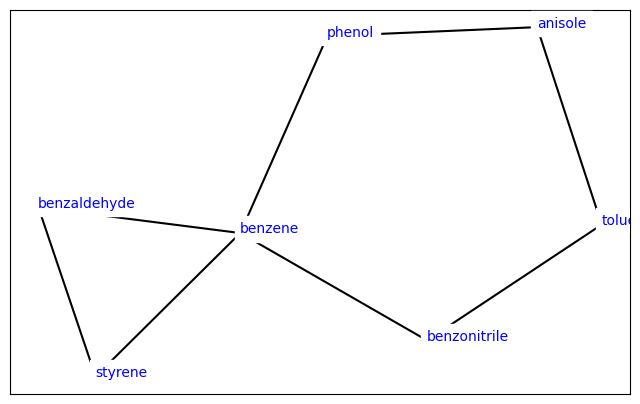

In [5]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network

plot_atommapping_network(lomap_network)